In [1]:
import sys
import jax
import equinox as eqx
import numpyro as npy
npy.set_host_device_count(2)
import dLux as dl
import chainconsumer as cc 
import jax.numpy as np
import jax.random as jr
import matplotlib.pyplot as plt
import numpyro.distributions as dist

In [2]:
%matplotlib inline
plt.figure()
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

In [3]:
def make_dict(dict_in, truth=False):
    """
    Just a convenience formatting function to latexise parameter names
    for plotting
    """
    znames = ['Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX']
    pos_names = ['Pos$_x$', 'Pos$_y$']
    name_dict = {'separation': 'r', 
                 'field_angle': r'$\phi$',\
                 'flux_ratio': 'Contrast', 
                 'flux':  r'$\overline{flux}$',
                 'bg_mean': '$\mu_{BG}$', 
                 'bg_var': '$\sigma_{BG}$'}
    
    dict_out = {}
    keys = list(dict_in.keys())
    for i in range(len(keys)):
        key = keys[i]
        if 'latent' in key or 'log' in key or 'theta' in key or 'pix' in key or key == 'bg':
            continue
        item = dict_in[key]
        if key == 'position':
            for j in range(item.shape[-1]):
                dict_out[pos_names[j]] = item[j] if truth else item[:, j]
                    
        elif key == 'coeffs':
            for j in range(item.shape[-1]):
                dict_out[znames[j]] = item[j] if truth else item[:, j]
        else:
            dict_out[name_dict[key]] = item

    return dict_out

In [4]:
# Load from the dev folder
sys.path.insert(1, "dLux/dLux/dev")
from base import *
from spectrums import *
from sources import *

# Create Combined Spectrum for Binary
nwavels = 3
wavels = np.linspace(400e-9, 500e-9, nwavels)
wavelengths = [wavels, wavels]
weights = [np.ones(nwavels), np.linspace(0.5, 1, nwavels)]
combined_spectrum = CombinedSpectrum(wavelengths, weights)

# Create Binary Source
true_position = np.zeros(2)
true_separation, true_field_angle = dl.utils.arcsec2rad(1e-1), 0
true_flux, true_flux_ratio = 1e5, 2
resolved = [False, False]
binary_source = BinarySource(true_position, true_flux, true_separation, 
                             true_field_angle, true_flux_ratio, 
                             combined_spectrum, resolved, name="Binary")

# Construct Optical system
wf_npix = 128
det_npix = 128
basis = dl.utils.zernike_basis(10, npix=wf_npix)[3:] * 1e-9
true_coeffs = jr.normal(jr.PRNGKey(0), (basis.shape[0],))
true_pixel_scale = dl.utils.arcsec2rad(5e-3)
layers = [dl.CreateWavefront(wf_npix, 1),
          dl.TiltWavefront(),
          dl.CompoundAperture([0.5]),
          dl.ApplyBasisOPD(basis, true_coeffs),
          dl.NormaliseWavefront(),
          dl.AngularMFT(true_pixel_scale, det_npix)]
osys = Optics(layers)

# Construct Detector
true_bg = 10.
true_pixel_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), (det_npix, det_npix))
detector = Detector([dl.AddConstant(true_bg)])

# Construct Telescope
telescope = Telescope(Optics(layers), 
                      Scene([binary_source]),
                      detector=detector)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


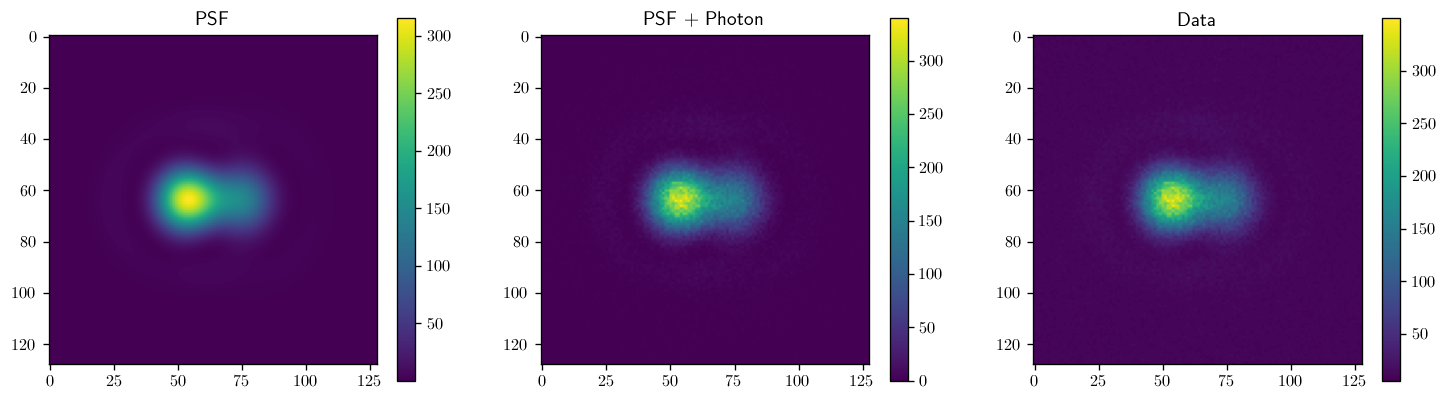

In [5]:
## Gerenate psf
psf = telescope.model_scene()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = true_bg + jr.normal(jr.PRNGKey(0), psf_photon.shape)
image = psf_photon+bg_noise
data = image.flatten()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
# plt.imshow(psf**0.25)
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF + Photon")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(image)
plt.colorbar()
plt.show()

In [6]:
def update_fn(position=None, separation=None, field_angle=None, flux=None, 
              flux_ratio=None, coeffs=None, pscale=None, bg=None, FF=None):
    """
    Update the paramaters with the given input value
    """
    # Define all the parameters
    params = (position, separation, field_angle, flux, 
              flux_ratio, coeffs, pscale, bg, FF)
    
    # Define paths to parameters we want 
    param_paths = [['scene',    'sources', 'Binary',             'position'       ],
                   ['scene',    'sources', 'Binary',             'separation'     ],
                   ['scene',    'sources', 'Binary',             'field_angle'    ],
                   ['scene',    'sources', 'Binary',             'flux'           ],
                   ['scene',    'sources', 'Binary',             'flux_ratio'     ],
                   ['optics',   'layers',  'Apply Basis OPD',    'coeffs'         ],
                   ['optics',   'layers',  'AngularMFT',         'pixel_scale_out'],
                   ['detector', 'layers',  'AddConstant',        'value'          ],
                   ['detector', 'layers',  'ApplyPixelResponse', 'pixel_response' ],
                   ]

    return params, param_paths

In [7]:
def psf_model(data, model=None):
    """
    
    """
    # Position
    position_pix = npy.sample("position_pix", dist.Uniform(-10, 10), sample_shape=(2,))
    position     = npy.deterministic('position', position_pix*true_pixel_scale)
    
    # Separation
    sep_min = true_separation - 10*true_pixel_scale
    sep_max = true_separation + 10*true_pixel_scale
    separation_log = npy.sample("log_separation", dist.Uniform(np.log10(sep_min), np.log10(sep_max)))
    separation     = npy.deterministic('separation', 10**(separation_log))
    
    # Field Angle (Position Angle)
    theta_x = npy.sample("theta_x", dist.Normal(0, 1))
    theta_y = npy.sample("theta_y", dist.Normal(0, 1))
    field_angle = npy.deterministic('field_angle', np.arctan2(theta_y, theta_x))
    
    # Flux
    flux_log = npy.sample("log_flux", dist.Uniform(4, 8))
    flux     = npy.deterministic('flux', 10**flux_log)
    
    # Flux ratio
    flux_ratio_log = npy.sample("log_flux_ratio", dist.Uniform(0, 4))
    flux_ratio     = npy.deterministic('flux_ratio', 10**flux_ratio_log)
    
    # Zernikes
    coeffs = npy.sample("coeffs", dist.Normal(0, 1), sample_shape=true_coeffs.shape)
    
    # Background
    bg = npy.sample("bg", dist.Uniform(5, 15))

    with npy.plate("data", len(data)):      
        poisson_model = dist.Poisson(model.update_and_model(update_fn, 
                                                            "model_image_flat",
                                                            position=position, 
                                                            separation=separation,
                                                            field_angle=field_angle, 
                                                            flux=flux,
                                                            flux_ratio=flux_ratio, 
                                                            coeffs=coeffs,
                                                            bg=bg,
                                                            ))
        return npy.sample("psf", poisson_model, obs=data)

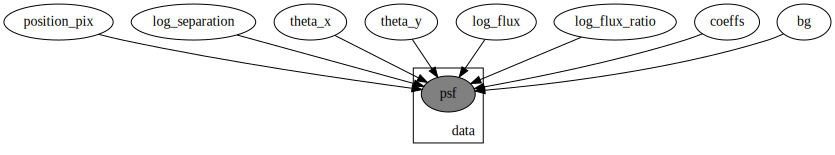

In [8]:
npy.render_model(psf_model, model_args=(data, telescope))

In [9]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, model=telescope)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 35min 38s, sys: 2min 50s, total: 38min 29s
Wall time: 7min 39s


In [18]:
sampler.print_summary()
values_out = sampler.get_samples()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              bg     10.01      0.03     10.01      9.96     10.05   2123.20      1.00
       coeffs[0]      0.02      1.00     -0.01     -1.75      1.50   1604.29      1.00
       coeffs[1]     -0.02      1.05     -0.02     -1.81      1.62   2609.13      1.00
       coeffs[2]      0.01      0.96      0.02     -1.56      1.56   2944.42      1.00
       coeffs[3]      0.38      0.28      0.38     -0.09      0.81   2758.99      1.00
       coeffs[4]     -1.17      0.22     -1.18     -1.53     -0.82   2173.65      1.00
       coeffs[5]      1.92      0.27      1.91      1.50      2.38   2610.62      1.00
       coeffs[6]     -0.50      0.25     -0.49     -0.90     -0.09   2386.68      1.00
        log_flux      5.00      0.00      5.00      5.00      5.00   3492.21      1.00
  log_flux_ratio      0.30      0.00      0.30      0.30      0.31   2139.14      1.00
  log_separation     -6.31      0.00     -

In [13]:
truth_dict = {'bg_mean':     true_bg,          'coeffs':   true_coeffs, 
              'field_angle': true_field_angle, 'flux':     true_flux, 
              'flux_ratio':  true_flux_ratio,  'position': true_position, 
              'separation':  true_separation,  'bg_var':   1.}

truth_dict_in = make_dict(truth_dict, truth=True)
chain_dict = make_dict(values_out)

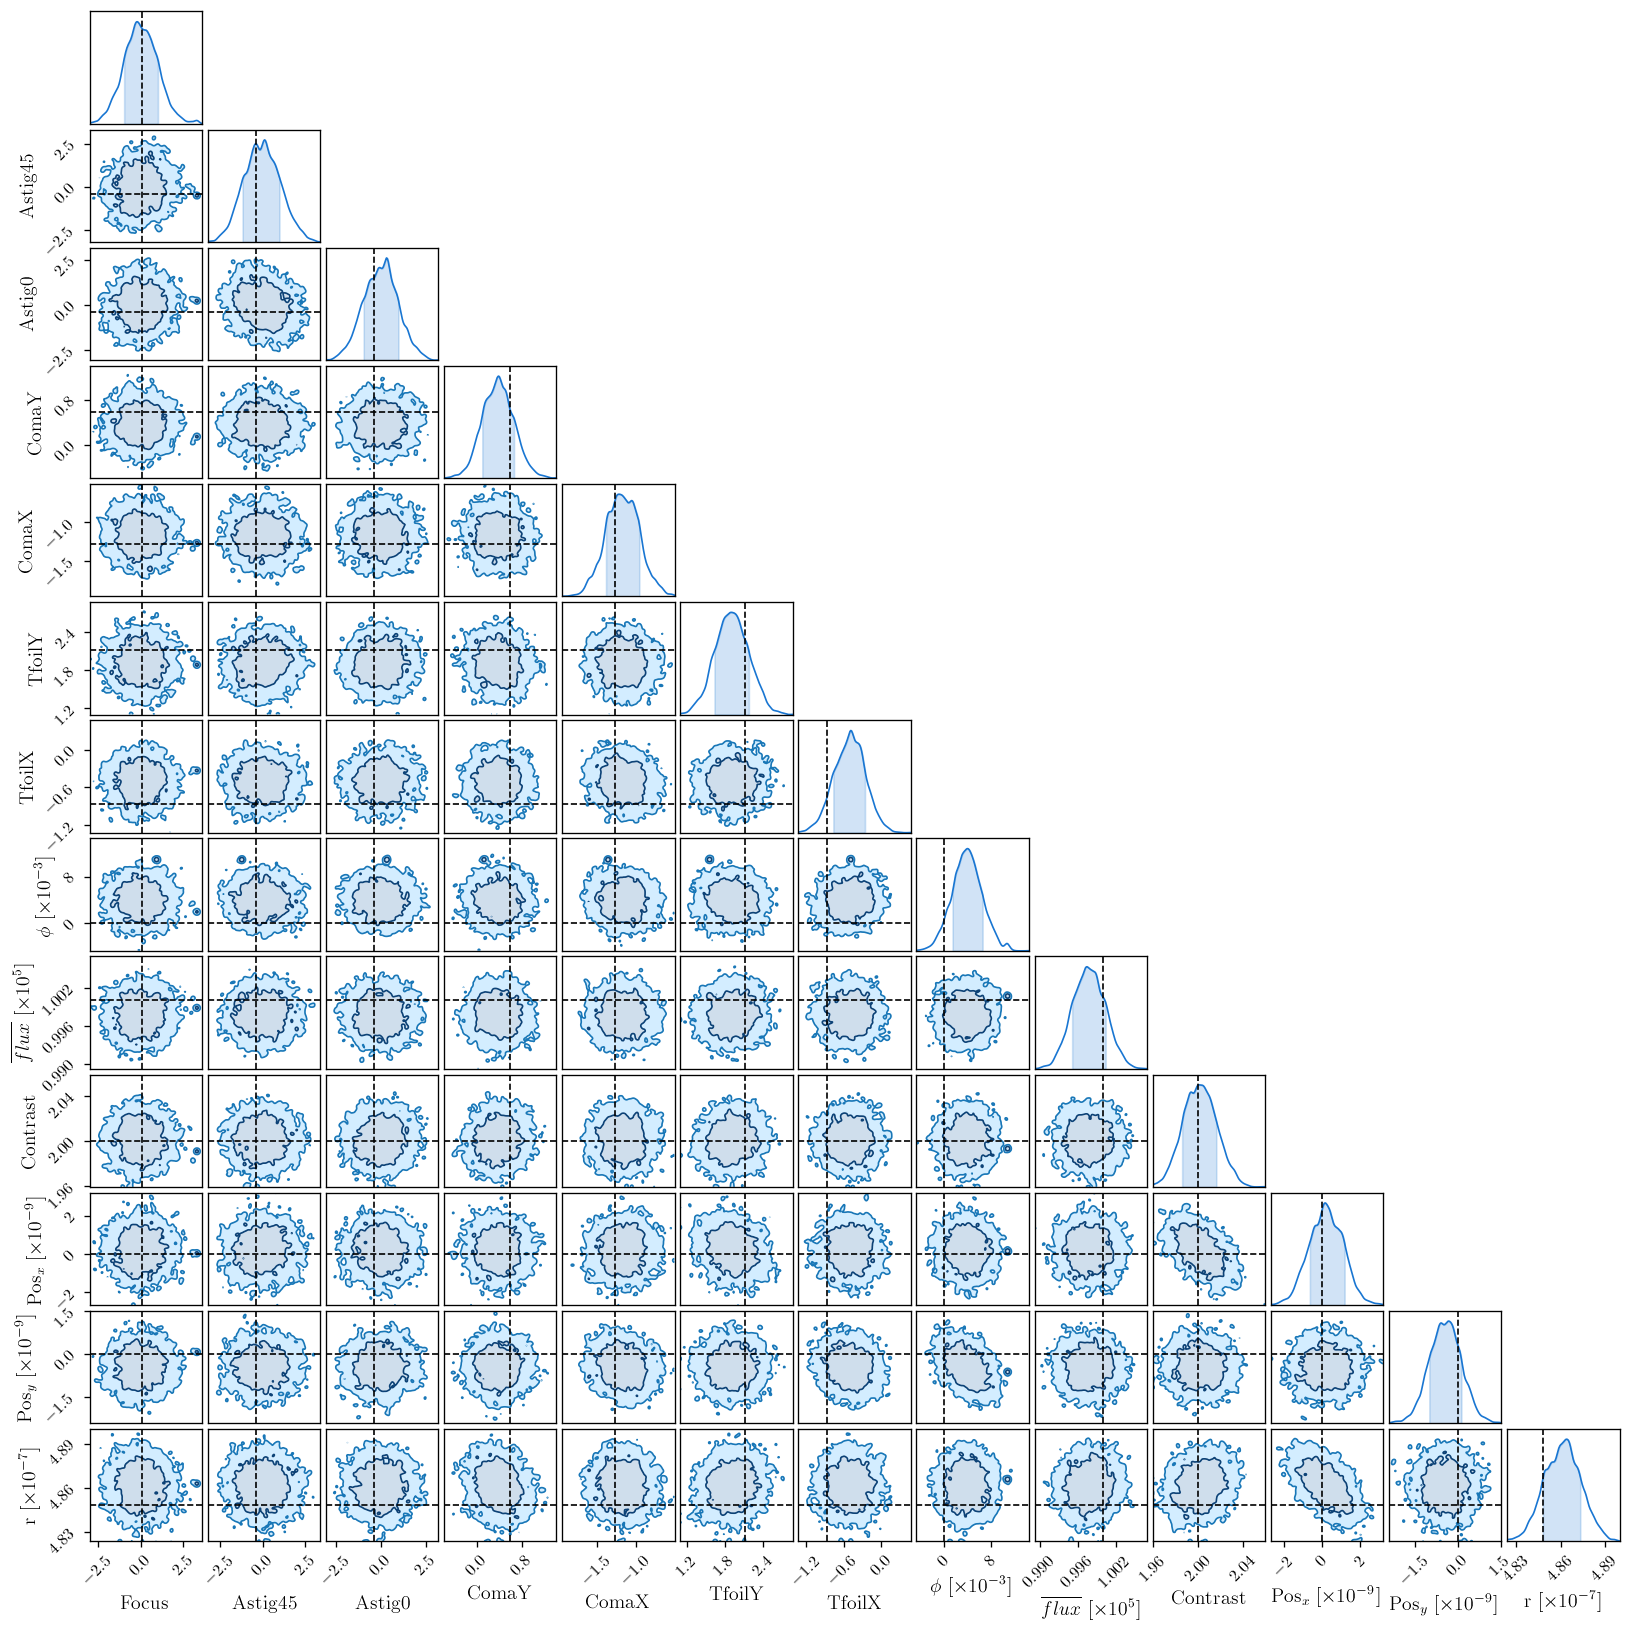

In [15]:
chain = cc.ChainConsumer()
chain.add_chain(chain_dict)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = chain.plotter.plot(truth=truth_dict_in)
fig.set_size_inches((15,15));